# Data loading

In [1]:
from google.colab import files
uploaded = files.upload()

Saving auto_mpg.csv to auto_mpg.csv


### Load libraries

In [3]:
import collections
import sys
import os
import io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go2
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

### Load uploaded files into pandas dataframa

In [4]:
df = pd.read_csv(io.BytesIO(uploaded['auto_mpg.csv']), sep=';')
SEED = 7
np.random.seed(SEED)
df_name = df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


### Check dataframe for missing data values

In [ ]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

### Check dataframe for categorical features

In [ ]:
df.describe(include='O')

,car_name
count,398
unique,305
top,ford pinto
freq,6


### Change car_name from string to numeric classification

In [5]:
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()
X_encoded = df.iloc[:, 8].values
X_encoded = label_encoder.fit_transform(X_encoded)
df.drop('car_name', axis=1)
df['car_name'] = X_encoded

### Data visualization of every data

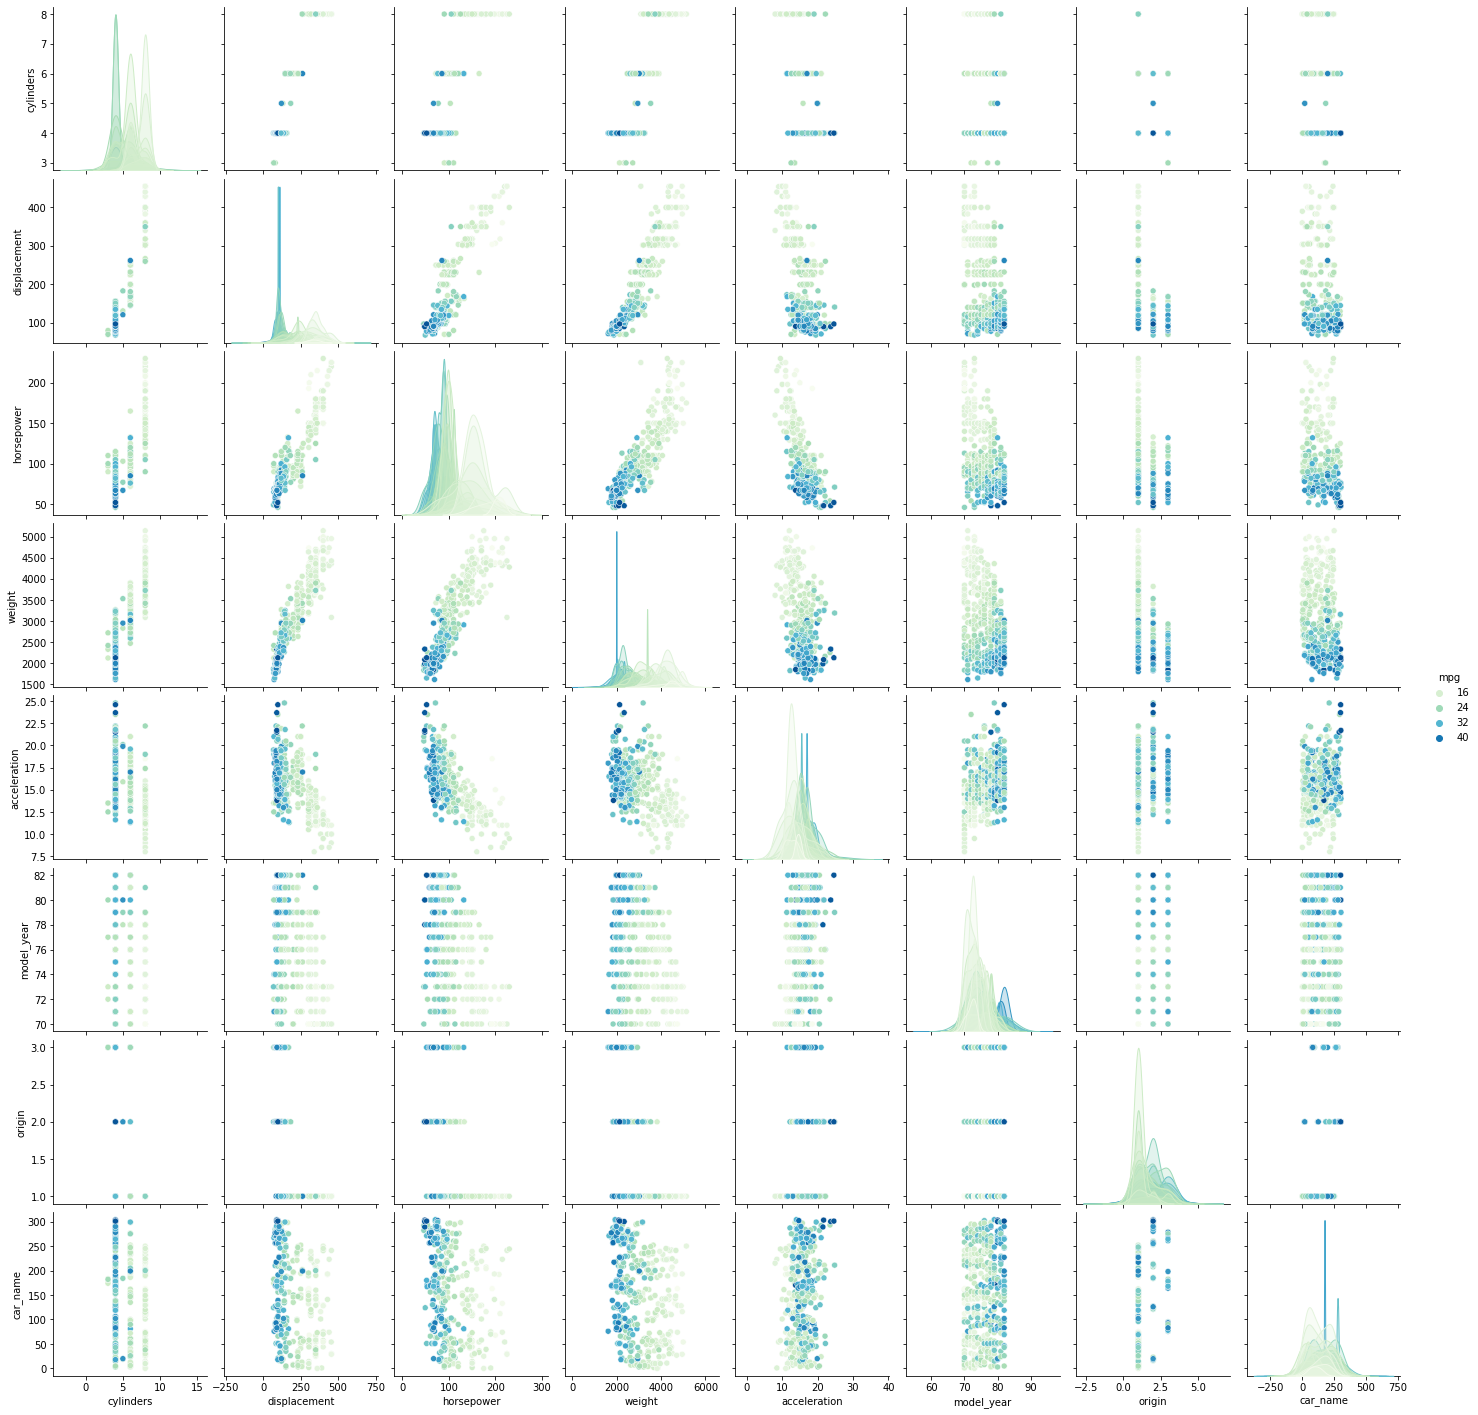

In [ ]:
g = sns.pairplot(df, hue='mpg', palette='GnBu')

# Outlier investigation

In [6]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [7]:
def OutLiersBox(df, nameOfFeature):
    trace0 = go.Box(
        y = df[nameOfFeature],
        name = "All Points",
        jitter = 0.3,
        pointpos = -1.8,
        boxpoints = 'all',
        marker = dict(
            color = 'rgb(7,40,89)'),
        line = dict(
            color = 'rgb(7,40,89)')
    )

    trace1 = go.Box(
        y = df[nameOfFeature],
        name = "Only Whiskers",
        boxpoints = False,
        marker = dict(
            color = 'rgb(9,56,125)'),
        line = dict(
            color = 'rgb(9,56,125)')
    )

    trace2 = go.Box(
        y = df[nameOfFeature],
        name = "Suspected Outliers",
        boxpoints = 'suspectedoutliers',
        marker = dict(
            color = 'rgb(8,81,156)',
            outliercolor = 'rgba(219, 64, 82, 0.6)',
            line = dict(
                outliercolor = 'rgba(219, 64, 82, 0.6)',
                outlierwidth = 2)),
        line = dict(
            color = 'rgb(8,81,156)')
    )

    trace3 = go.Box(
        y = df[nameOfFeature],
        name = "Whiskers and Outliers",
        boxpoints = 'outliers',
        marker = dict(
            color = 'rgb(107,174,214)'),
        line = dict(
            color = 'rgb(107,174,214)')
    )

    data = [trace0,trace1,trace2,trace3]

    layout = go.Layout(
        title = "{} Outliers".format(nameOfFeature)
    )

    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig, filename = "Outliers")

### Outlier investigation 

In [ ]:
for i in range(len(df.columns)):
  configure_plotly_browser_state()
  OutLiersBox(df, df_name[i])

Data training before removing outliers

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [ ]:
X_unclean = df.drop('car_name', axis=1).drop('mpg', axis=1)
y_unclean = df['mpg']
X_train_unclean, X_test_unclean, y_train_unclean, y_test_unclean = train_test_split(X_unclean, y_unclean, test_size=0.2, random_state=42)

In [ ]:
model = SVR()
model.fit(X_train_unclean, y_train_unclean)
first_prediction = model.predict(X_test_unclean)
mse = mean_squared_error(y_test_unclean, first_prediction) 
rmse = mean_squared_error(y_test_unclean, first_prediction, squared=False)
r2 = r2_score(y_test_unclean, first_prediction)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MSE: 13.735021502057913
RMSE: 3.706078992959798
R2: 0.7445428683004925


### Remove outliers

In [9]:
def TurkyOutliers(df_out, nameOfFeature, drop=False):
  valueOfFeature = df_out[nameOfFeature]
  Q1 = np.percentile(valueOfFeature, 25.)
  Q3 = np.percentile(valueOfFeature, 75.)

  step = (Q3 - Q1) * 1.5
  outliers = valueOfFeature[~((valueOfFeature >= Q1 - step) & (valueOfFeature <= Q3 + step))].index.tolist()
  feature_outliers = valueOfFeature[~((valueOfFeature >= Q1 - step) & (valueOfFeature <= Q3 + step))].values

  print ("Number of outliers (inc duplicates): {} and outliers: {}".format(len(outliers), feature_outliers))
  if drop:
      good_data = df_out.drop(df_out.index[outliers]).reset_index(drop = True)
      print ("New dataset with removed outliers has {} samples with {} features each.".format(*good_data.shape))
      return good_data
  else: 
      print ("Nothing happens, df.shape = ", df_out.shape)
      return df_out

In [10]:
df_clean = df.copy()
df_clean_name = df_clean.columns

### Remove outlier in horsepower

In [11]:
feature_number = df.columns.get_loc('horsepower')
df_clean = TurkyOutliers(df_clean, df_name[feature_number], True)
configure_plotly_browser_state()
OutLiersBox(df_clean, df_clean_name[feature_number])

Number of outliers (inc duplicates): 10 and outliers: [220. 215. 225. 225. 215. 210. 208. 215. 225. 230.]
New dataset with removed outliers has 388 samples with 9 features each.


### Remove outlier for acceleration

In [12]:
feature_number = df.columns.get_loc('acceleration')
df_clean = TurkyOutliers(df_clean, df_name[feature_number], True)
configure_plotly_browser_state()
OutLiersBox(df_clean, df_clean_name[feature_number])

Number of outliers (inc duplicates): 6 and outliers: [ 8.5  8.  23.5 24.8 23.7 24.6]
New dataset with removed outliers has 382 samples with 9 features each.


It seems that after removal of outlier, there are still some outliers in the data.

Review effect of outlier to MSE and RMSE

In [ ]:
X_cleaned = df_clean.drop('car_name', axis=1).drop('mpg', axis=1)
y_cleaned = df_clean['mpg']
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

In [ ]:
model = SVR()
model.fit(X_train_cleaned, y_train_cleaned)
second_prediction = model.predict(X_test_cleaned)
mse = mean_squared_error(y_test_cleaned, second_prediction) 
rmse = mean_squared_error(y_test_cleaned, second_prediction, squared=False)
r2 = r2_score(y_test_cleaned, second_prediction)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MSE: 13.499339259908623
RMSE: 3.6741446977369607
R2: 0.7772740095740611


The MSE and RMSE appears to be lower. Removing some of the outliers does have a positive impact onto the model. Nevertheless, excessive removal of outliers decrease the datasets available for training, and indirectly produce a slightly inaccurate model. The R^2 score has improved slightly.

If there are more datasets, outlier removal is a good idea.

# Spilting Data 

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression, mutual_info_classif

In [14]:
y = df_clean['mpg'].values
X = df_clean.drop('mpg', axis=1)

### Identify input features that have high correlation with target variable

In [ ]:
important_features = full_data.drop('mpg', axis=1).apply(lambda x: x.corr(full_data.mpg))
indices = np.argsort(important_features)
print(important_features[indices])

weight         -0.814735
displacement   -0.785324
horsepower     -0.773507
cylinders      -0.734592
car_name        0.260254
acceleration    0.260729
model_year      0.505971
origin          0.538914
dtype: float64


### Plot data for visualization

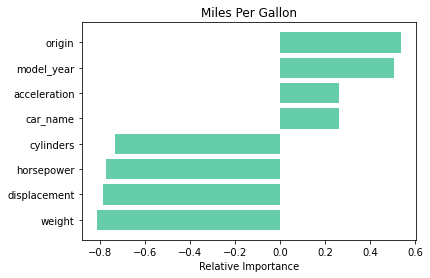

In [ ]:
names = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
plt.title('Miles Per Gallon')
plt.barh(range(len(indices)), important_features[indices], color='mediumaquamarine', align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
for i in range(0, len(indices)):
  if np.abs(important_features[i]) > 0.4:
    print(names[i])

cylinders
displacement
horsepower
weight
model_year
origin


### Identify input features that have a low correlation with other independent variable 

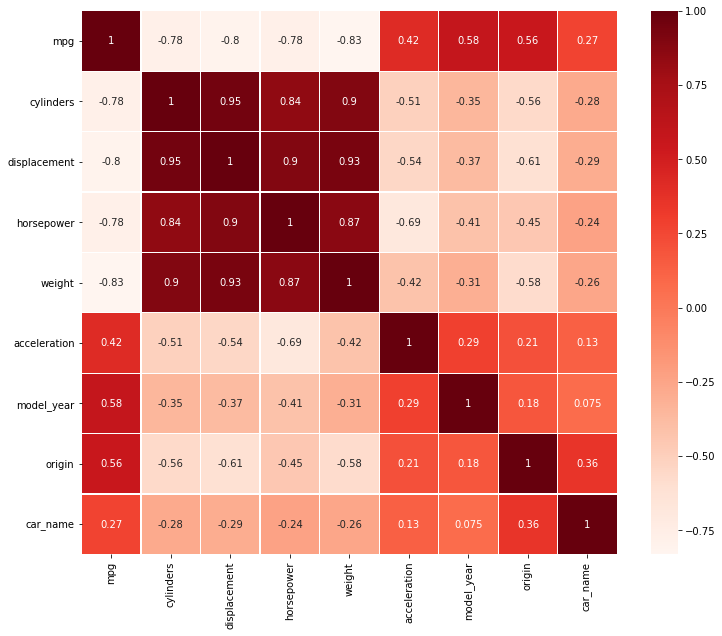

In [ ]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, linewidths=0.35)
sns.set(font_scale=1.1)
plt.show()

In [ ]:
y = df_clean['mpg'].values
X = df_clean.drop('car_name', axis=1).drop('mpg', axis=1)

SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
possible_features = df.columns.copy().drop('mpg').drop('car_name')
selector = SelectKBest(f_regression, len(possible_features))
selector.fit(X[possible_features], y)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print('Feature importances:')
for i in range(len(scores)):
    print('%.2f %s' % (scores[indices[i]], possible_features[indices[i]]))

Feature importances:
97.91 weight
86.70 displacement
81.22 horsepower
74.21 cylinders
31.84 origin
30.87 model_year
12.41 acceleration


In [ ]:
for i in range(0, len(X.columns)):
  for j in  range(0, len(X.columns)):
    if i != j:
      correlation = np.abs(X[X.columns[i]].corr(X[X.columns[j]]))
      if correlation < 0.3:
        print(X.columns[i] , " is not correlated  with ", X.columns[j])
      elif correlation > 0.75:
        print(X.columns[i] , " is highly  correlated  with ", X.columns[j])

cylinders  is highly  correlated  with  displacement
cylinders  is highly  correlated  with  horsepower
cylinders  is highly  correlated  with  weight
cylinders  is not correlated  with  model_year
displacement  is highly  correlated  with  cylinders
displacement  is highly  correlated  with  horsepower
displacement  is highly  correlated  with  weight
displacement  is not correlated  with  model_year
horsepower  is highly  correlated  with  cylinders
horsepower  is highly  correlated  with  displacement
horsepower  is highly  correlated  with  weight
horsepower  is not correlated  with  model_year
weight  is highly  correlated  with  cylinders
weight  is highly  correlated  with  displacement
weight  is highly  correlated  with  horsepower
weight  is not correlated  with  acceleration
weight  is not correlated  with  model_year
acceleration  is not correlated  with  weight
acceleration  is not correlated  with  model_year
acceleration  is not correlated  with  origin
model_year  is no

Horsepower and displacement is removed in filter method to avoid multicolinearity

RFE Cross Validation

Optimal number of features: 6
Selected features: ['cylinders', 'displacement', 'horsepower', 'acceleration', 'model_year', 'origin']


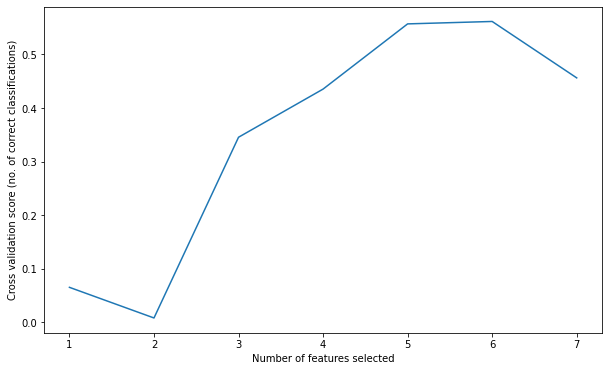

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)
rfecv = selector.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (no. of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Compare feature selection using filter method

In [ ]:
X_filter = df_clean[['cylinders', 'weight', 'model_year', 'origin']]
y_filter = df_clean['mpg'].values

X_train_Filter, X_test_Filter, y_train_Filter, y_test_Filter = train_test_split(X_filter, y_filter, test_size=0.2, random_state=42)

model = SVR()
model.fit(X_train_Filter, y_train_Filter)
FS_prediction = model.predict(X_test_Filter)
mse = mean_squared_error(y_test_Filter, FS_prediction) 
rmse = mean_squared_error(y_test_Filter, FS_prediction, squared=False)
r2 = r2_score(y_test_Filter, FS_prediction)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MSE: 13.415934855125192
RMSE: 3.662776932209385
R2: 0.7786501012703744


Compare feature selection using wrapper method

In [ ]:
X_wrapper = df_clean[['cylinders', 'horsepower', 'displacement', 'model_year', 'origin']]
y_wrapper = df_clean['mpg'].values

X_train_wrapper, X_test_wrapper, y_train_wrapper, y_test_wrapper = train_test_split(X_wrapper, y_wrapper, test_size=0.2, random_state=42)

model = SVR()
model.fit(X_train_wrapper, y_train_wrapper)
FS2_prediction = model.predict(X_test_wrapper)
mse = mean_squared_error(y_test_wrapper, FS2_prediction) 
rmse = mean_squared_error(y_test_wrapper, FS2_prediction, squared=False)
r2 = r2_score(y_test_wrapper, FS2_prediction)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MSE: 13.250211336559746
RMSE: 3.6400839738335358
R2: 0.7813843784152552


Wrapper method produced a better results compared to filter method.

### Feature selection

In [ ]:
X = df_clean[['cylinders', 'horsepower', 'displacement', 'model_year', 'origin']]
y = df_clean['mpg'].values

### Find information gain of the independent variable with respect to a target variable

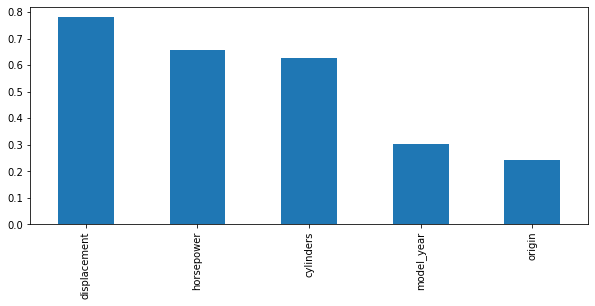

In [ ]:
mi = mutual_info_regression(X, y)
mi = pd.Series(mi)
mi.index = X.columns
mi.sort_values(ascending=False)
mi.sort_values(ascending=False).plot.bar(figsize=(10, 4))

Feature selection does improve the MSE and RMSE slightly. Nonetheless, it is still preferable to perform feature selection to reduce training time.

### Data standardisation

In [15]:
standard_scaler = StandardScaler()
standard_scaler.fit(X)
X_Standard = standard_scaler.transform(X)

In [16]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X)
X_MinMax = minmax_scaler.transform(X)

Review the impact of different scaler onto the MSE and RMSE

In [ ]:
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_Standard, y, test_size=0.2, random_state=42)

In [ ]:
model = SVR()
model.fit(X_train_S, y_train_S)
fourth_prediction = model.predict(X_test_S)
mse = mean_squared_error(y_test_S, fourth_prediction) 
rmse = mean_squared_error(y_test_S, fourth_prediction, squared=False)
r2 = r2_score(y_test_S, fourth_prediction)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MSE: 8.457002057524607
RMSE: 2.908092511858006
R2: 0.8604676774891928


In [ ]:
X_train_MinMax, X_test_MinMax, y_train_MinMax, y_test_MinMax = train_test_split(X_MinMax, y, test_size=0.2, random_state=42)

In [ ]:
model = SVR()
model.fit(X_train_MinMax, y_train_MinMax)
fifth_prediction = model.predict(X_test_MinMax)
mse = mean_squared_error(y_test_MinMax, fifth_prediction) 
rmse = mean_squared_error(y_test_MinMax, fifth_prediction, squared=False)
r2 = r2_score(y_test_MinMax, fifth_prediction)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MSE: 8.31641610304892
RMSE: 2.8838197070983687
R2: 0.862787209234244


In this scenario, it seems MinMax Scaler produce a better performance compared to Standard Scaler

In [17]:
X = X_MinMax

In [ ]:
y_scaler = MinMaxScaler()
y_scaler.fit(y.reshape(-1, 1))
y_Scaled = y_scaler.transform(y.reshape(-1, 1))
y = y_Scaled

In [ ]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = SVR()
model.fit(X_train_scaled, y_train_scaled)
y_scaled_prediction = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_test_scaled) 
rmse = mean_squared_error(y_test, y_test_scaled, squared=False)
r2 = r2_score(y_test, y_test_scaled)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MSE: 0.0064465305380742325
RMSE: 0.08029028918913067
R2: 0.8496303734877942


### Split dataset into training set and testing set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameter tuning

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split

svrgs_parameters = {
    'kernel': ['rbf', 'poly'],
    'C':      [1.0, 2.0, 3.0, 6.0, 10],
    'gamma':  ['scale', 'auto'],
}

svr_cv = GridSearchCV(svm.SVR(), svrgs_parameters, cv=8, scoring= 'neg_mean_squared_error')
svr_cv.fit(X_train, y_train)
print("SVR GridSearch score: "+ str(svr_cv.best_score_))
print("SVR GridSearch params: " + str(svr_cv.best_params_))

SVR GridSearch score: -0.006445293034699274
SVR GridSearch params: {'C': 6.0, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
model_svr_best = SVR(kernel='rbf', C=25, gamma='scale')
model_svr_best.fit(X_train, y_train)

SVR(C=25, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
final_prediction = model_svr_best.predict(X_test)
mse = mean_squared_error(y_test, final_prediction) 
rmse = mean_squared_error(y_test, final_prediction, squared=False)
r2 = r2_score(y_test, final_prediction)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MSE: 0.005946537115491881
RMSE: 0.07711379328947501
R2: 0.8612930537106243


We had succesfully reduce the MSE and RMSE by a huge margin, low value of the metric performance is due to the MinMaxScaler used. When we perform inverse_transform onto the prediction and y_test, the MSE and RMSE shows a significant improvement compared to none scaled. R^2 score would provide a much better metrics as comparison. Nevertheless, R^2 improved slightly.

Let's try to optimize the model for R^2 scoring

In [23]:
y = df_clean['mpg'].values
X = X_Standard
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split

svrgs_parameters = {
    'kernel': ['rbf', 'poly'],
    'C':      [10, 15, 20, 22, 24],
    'gamma':  ['scale', 'auto'],
}

svr_cv = GridSearchCV(svm.SVR(), svrgs_parameters, cv=8, scoring= 'r2')
svr_cv.fit(X_train, y_train)
print("SVR GridSearch score: "+ str(svr_cv.best_score_))
print("SVR GridSearch params: " + str(svr_cv.best_params_))

SVR GridSearch score: 0.8711350500307188
SVR GridSearch params: {'C': 22, 'gamma': 'auto', 'kernel': 'rbf'}


In [63]:
model_svr_best = SVR(kernel='rbf', C=24, gamma='scale')
model_svr_best.fit(X_train, y_train)

SVR(C=24, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [64]:
final_prediction = model_svr_best.predict(X_test)
mse = mean_squared_error(y_test, final_prediction) 
rmse = mean_squared_error(y_test, final_prediction, squared=False)
r2 = r2_score(y_test, final_prediction)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

MSE: 6.554197802252441
RMSE: 2.5601167555899558
R2: 0.8918621001481469


### Conclusion

It seems that MinMaxScaler produces a lower MSE and RMSE while StandardScaler produce a higher R2 score. While MSE and RMSE is dependent onto the scaler, R2 would be a better perfomance metrics in this scenario.

### Data visualization of the SVR

In [66]:
def SVR_Visualize(df):
  mesh_size = 0.2
  margin = 0

  X = df[['cylinders', 'horsepower']]
  y = df['mpg']

  model_svr_best = SVR(kernel='rbf', C=24, gamma='auto')
  model_svr_best.fit(X, y)

  x_min, x_max = X.cylinders.min() - margin, X.cylinders.max() + margin
  y_min, y_max = X.horsepower.min() - margin, X.horsepower.max() + margin
  xrange = np.arange(x_min, x_max, mesh_size)
  yrange = np.arange(y_min, y_max, mesh_size)
  xx, yy = np.meshgrid(xrange, yrange)

  pred = model_svr_best.predict(np.c_[xx.ravel(), yy.ravel()])
  pred = pred.reshape(xx.shape)

  configure_plotly_browser_state()

  markersize = df['displacement'] / 12
  markercolor = df['origin']

  trace = go.Scatter3d(
      x = df['cylinders'],
      y = df['horsepower'],
      z = df['mpg'],
      mode = 'markers',
      marker = dict(
          size=markersize,
          color=markercolor,
          opacity=0.9,
          reversescale=True,
          colorscale='Sunset'
      ),
  )

  layout = go.Layout(
      scene = dict(
          xaxis=dict(title='Cylinders'),
          yaxis=dict(title='Horsepower'),
          zaxis=dict(title='Mpg'),
      )
  )

  fig = go.Figure(data=[trace])
  fig.add_traces(go2.Surface(x=xrange, y=yrange, z=pred, name='pred_surface'))
  fig.show()

In [67]:
SVR_Visualize(df_clean)